In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

In [47]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [48]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.style.use('seaborn-notebook')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (20,10)

# EDA

In [49]:
data_path = 'data.csv'

In [50]:
df = pd.read_csv(data_path, sep=',')

In [51]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24334 entries, 0 to 24333
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   order_id                      24334 non-null  int64  
 1   cred_sum_cc_all               24334 non-null  float64
 2   mfo_inqs_count_month          24334 non-null  int64  
 3   all_closed_creds_sum_all      24334 non-null  int64  
 4   bank_inqs_count_quarter       24334 non-null  int64  
 5   cred_max_overdue_max_ly       24334 non-null  float64
 6   all_active_creds_sum_all      24334 non-null  int64  
 7   mfo_last_days_all             24334 non-null  int64  
 8   cred_sum_cc_ly                24334 non-null  float64
 9   cred_sum_debt_all_all         24334 non-null  float64
 10  all_closed_creds_sum_ly       24334 non-null  int64  
 11  mfo_cred_mean_sum_3lm         24334 non-null  float64
 12  delay_more_sum_all            24334 non-null  int64  
 13  a

,order_id,cred_sum_cc_all,mfo_inqs_count_month,all_closed_creds_sum_all,bank_inqs_count_quarter,cred_max_overdue_max_ly,all_active_creds_sum_all,mfo_last_days_all,cred_sum_cc_ly,cred_sum_debt_all_all,...,cred_max_overdue_max_3lm,mfo_closed_count_ly,cred_sum_overdue_cc_all,count_overdue_all_3lm,all_creds_count_lm,work_code,month_income,region,bad,approved
0,5498546,0.0,0,40364,0,0.0,3000,560,0.0,0.0,...,0.0,0,0.00,0,0,3,50000,46,NaN,0
1,5498604,1500.0,0,23456,0,0.0,0,9999,0.0,0.0,...,0.0,0,0.00,0,0,3,35000,17,NaN,0
2,5498609,0.1,0,17999,3,0.0,9999,9999,0.1,9999.0,...,0.0,0,0.00,0,2,3,35000,58,NaN,0
3,5498645,5000.0,0,313247,0,0.0,0,9999,0.0,0.0,...,0.0,0,4923.97,0,0,5,35000,4,NaN,0
4,5498647,0.0,0,0,1,0.0,0,9999,0.0,0.0,...,0.0,0,0.00,0,0,5,35000,34,NaN,0


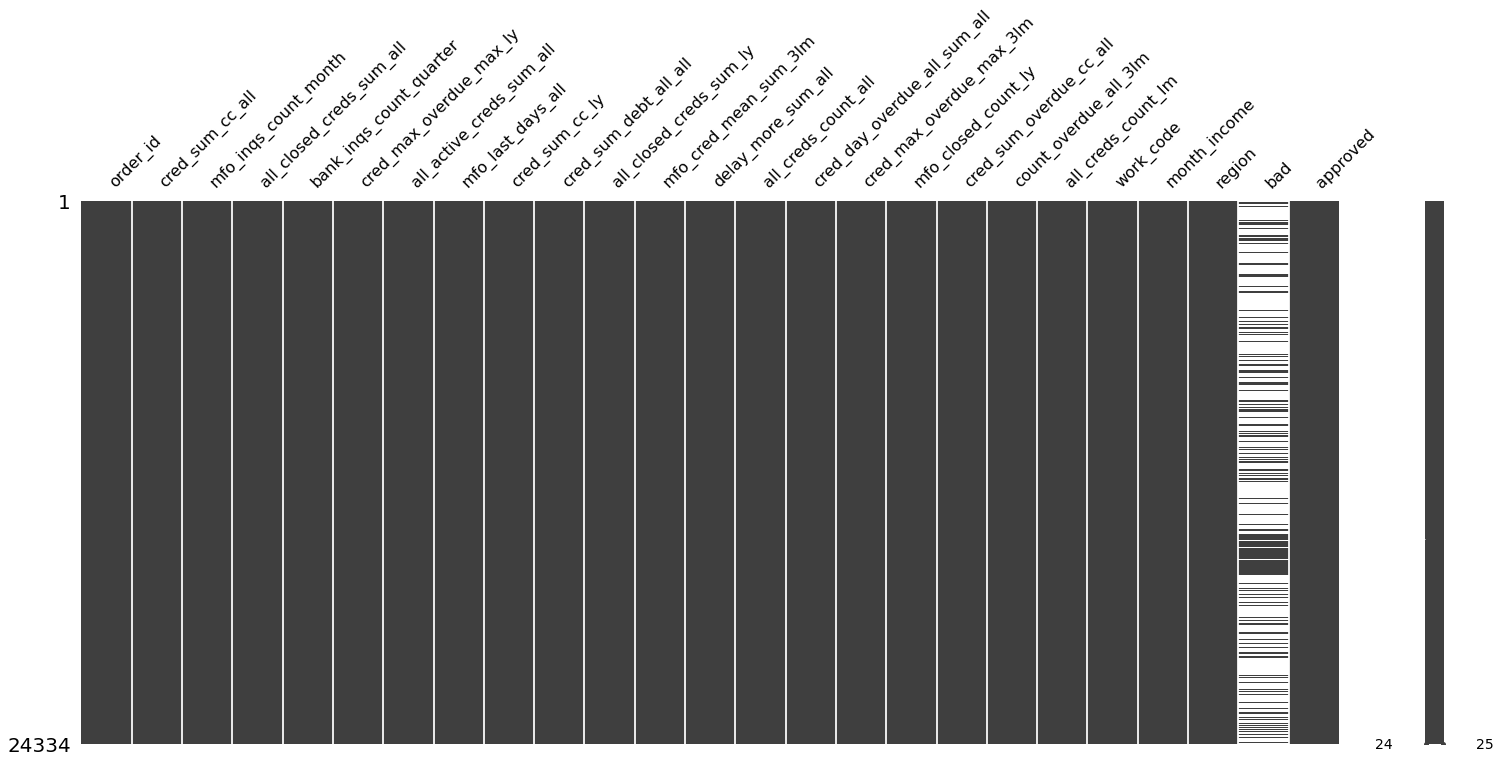

In [52]:
missingno.matrix(df);

We can see a lot of NaN values in target *bad*. In order to get strong results of our model later it would be good to discard this data or mark it somehow. Let's start with discarding *NaN*s.

# Discarding *NaN*s

*Bad*=*NaN* means that loan wasn't approved for that person. Hence, we can select part of dataset where *approved*=1 instead of discarding *bad*=*NaN*

In [53]:
df_approved = df[df['approved'] == 1]
df_bad = df_approved[df_approved['bad'] == 1]
df_not_bad = df_approved[df_approved['bad'] == 0]

df_bad = df_bad.drop(['order_id', 'bad', 'approved'], axis=1)
df_not_bad = df_not_bad.drop(['order_id', 'bad', 'approved'], axis=1)

num_columns = df_bad.shape[1]

## Look at the features distributions for *bad*=1 and *bad*=0

In [54]:
# For subplots
nrow = num_columns
ncol = 2

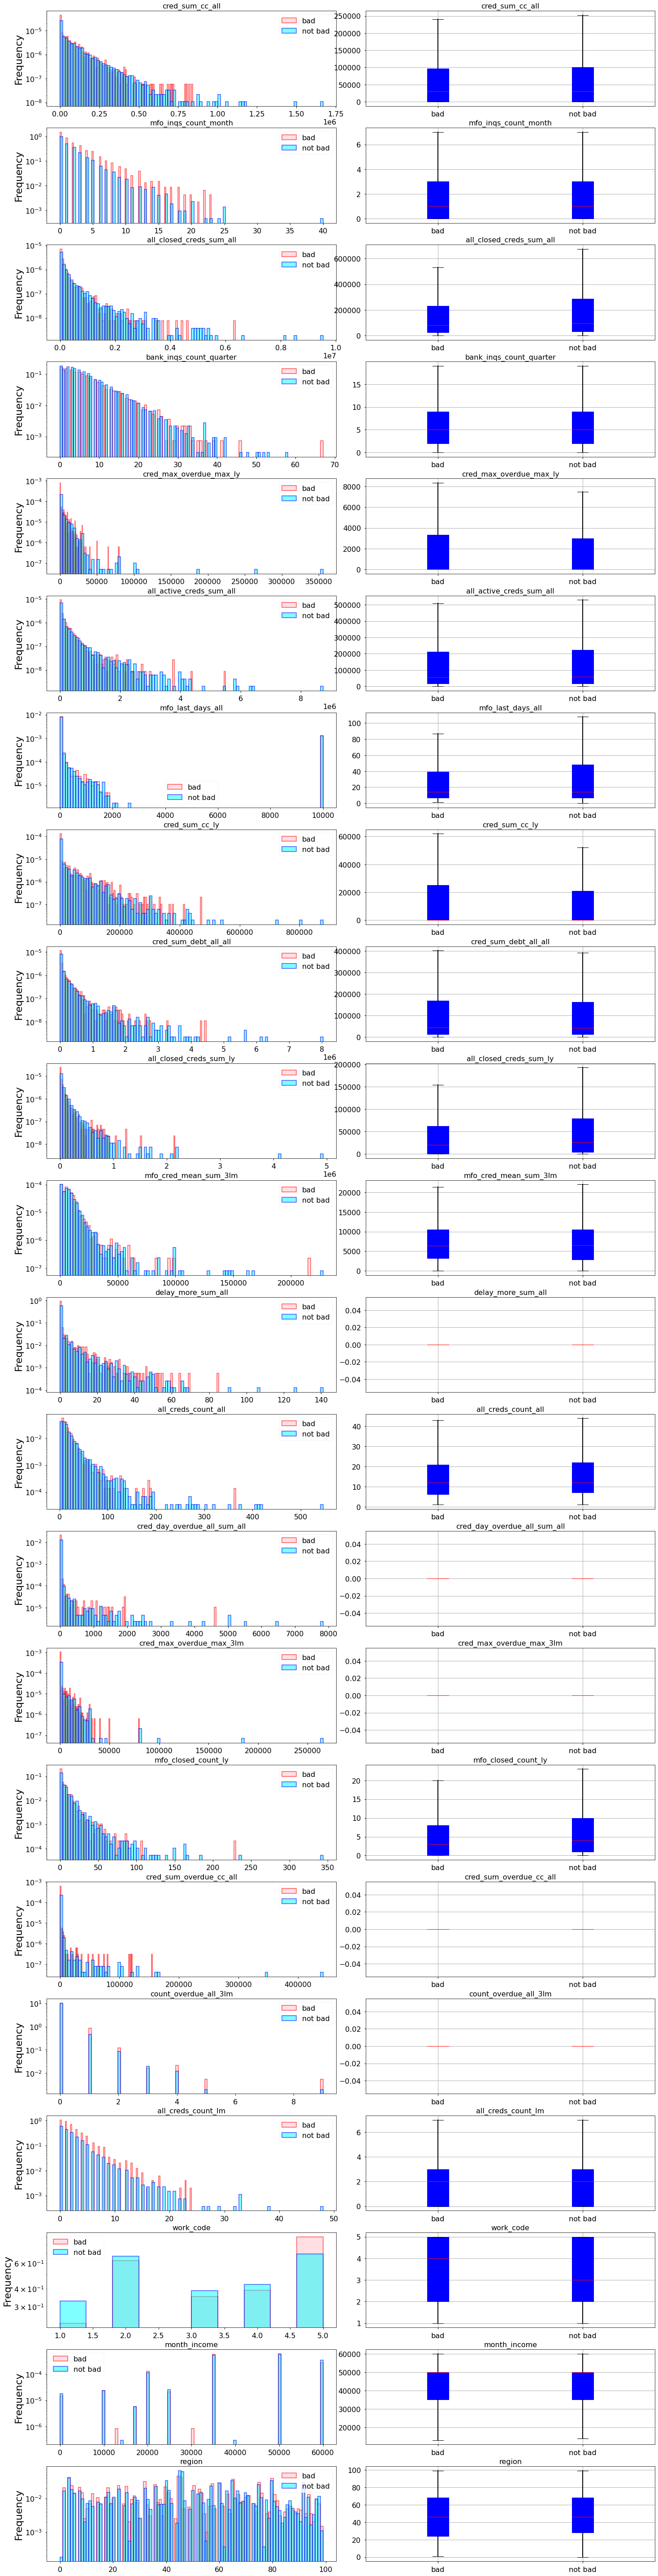

In [55]:
# Plotting hists

fig, axes = plt.subplots(nrow, ncol, figsize=(20,80))
fig.tight_layout()

hist_params = {'linewidth':2, 'density':True, 'log':True, 'alpha':0.5}
labels = ['bad', 'not bad']
color = dict(boxes='blue', whiskers='black', medians='red', caps='black')

for i in range(nrow):
    # Hists
    bins_num = 100 if df_bad.columns[i] != 'work_code' else 10
    df_bad[df_bad.columns[i]].plot.hist(**hist_params, color='pink', edgecolor='red', bins=bins_num, label='bad', ax=axes[i][0])
    df_not_bad[df_not_bad.columns[i]].plot.hist(**hist_params, color='cyan', edgecolor='blue', bins=bins_num, label='not bad', ax=axes[i][0])
    axes[i][0].legend()
    axes[i][0].set_title(f'{df_not_bad.columns[i]}')

    # Boxplots
    feature_pair = pd.concat([df_bad[[df_bad.columns[i]]], df_not_bad[[df_not_bad.columns[i]]]], axis=1)
    bp = feature_pair.boxplot(showfliers=False, patch_artist=True, ax=axes[i][1], whiskerprops = dict(linewidth=2.0, color='black'), color=color)
    bp.set_xticks(range(1, 3))
    bp.set_xticklabels(labels)
    axes[i][1].set_title(f'{df_not_bad.columns[i]}')

We can see that there are neither obviously useful and significant features nor useless and minor ones. Therefore, we won't drop any of them out before learning process.


## Check if the classes are balanced

bad
0.0    5580
1.0    2062
dtype: int64


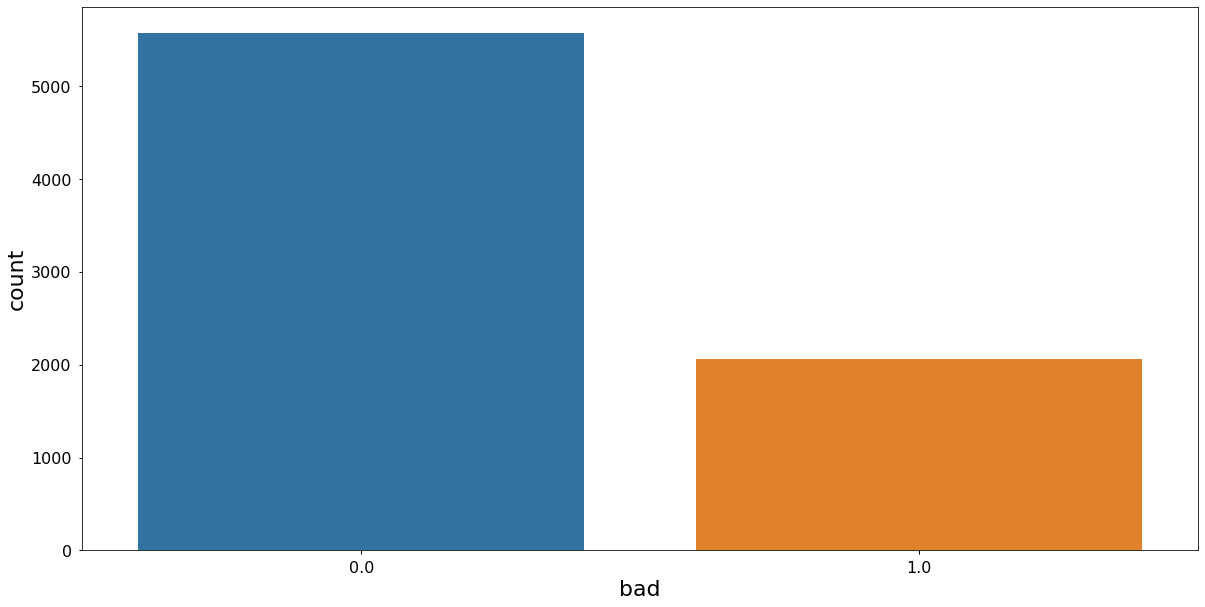

In [56]:
print(df_approved.value_counts('bad'))
sns.countplot(x='bad', data=df_approved);

We can see significant class imbalance here. This will affect the results. Let's try to train the model on this data

In [57]:
X = df_approved.drop(['order_id', 'approved', 'bad'], axis=1)
y = df_approved[['bad']]

## Train-test data prepatation

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scaling and converting to numpy

In [59]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [60]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [61]:
X_train.shape, X_test.shape

(torch.Size([6113, 22]), torch.Size([1529, 22]))

## Model

In [62]:
BATCH_SIZE = 64
EPOCHS = 25
LEARNING_RATE=0.0001

In [63]:
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


class TestData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        return self.X_data[index]

    def __len__ (self):
        return len(self.X_data)

train_data = TrainData(X_train,y_train)
test_data = TestData(X_test)

In [64]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [65]:
class BinaryClassificationBad(torch.nn.Module):
    def __init__(self, num_input_neurons):
        super(BinaryClassificationBad, self).__init__()

        self.fc1 = torch.nn.Linear(num_input_neurons, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 1)

        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.1)
        self.batch_norm_1 = torch.nn.BatchNorm1d(128)
        self.batch_norm_2 = torch.nn.BatchNorm1d(128)

    def forward(self, inputs):
        x = self.fc1(inputs)
        x = self.relu(x)
        x = self.batch_norm_1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.batch_norm_2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

net = BinaryClassificationBad(X_train.shape[1])

In [66]:
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=LEARNING_RATE)

In [67]:
def binary_acc(preds, targets):
    y_pred_tag = torch.round(torch.sigmoid(preds))

    correct_results_sum = (y_pred_tag == targets).sum().float()
    acc = correct_results_sum / targets.shape[0]
    acc *= 100

    return acc

## Learning

In [68]:
test_accuracy_history = []
test_loss_history = []
train_accuracy_history = []
train_loss_history = []

for e in range(1, EPOCHS+1):
    net.train()
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, target_batch in train_loader:
        optimizer.zero_grad()

        pred_batch = net(X_batch)

        loss_val = loss(pred_batch, target_batch)
        acc = binary_acc(pred_batch, target_batch)

        loss_val.backward()
        optimizer.step()

        epoch_loss += loss_val.item()
        epoch_acc += acc.item()

    net.eval()
    test_preds = net.forward(X_test)
    train_preds = net.forward(X_train)

    test_loss_history.append(loss(test_preds, y_test).item())
    test_accuracy_history.append(binary_acc(test_preds, y_test))

    train_loss_history.append(loss(train_preds, y_train).item())
    train_accuracy_history.append(binary_acc(train_preds, y_train))

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.71994 | Acc: 49.312
Epoch 002: | Loss: 0.68917 | Acc: 55.778
Epoch 003: | Loss: 0.66953 | Acc: 59.538
Epoch 004: | Loss: 0.65584 | Acc: 62.383
Epoch 005: | Loss: 0.63955 | Acc: 65.292
Epoch 006: | Loss: 0.63139 | Acc: 66.648
Epoch 007: | Loss: 0.61780 | Acc: 68.466
Epoch 008: | Loss: 0.60301 | Acc: 68.841
Epoch 009: | Loss: 0.59450 | Acc: 70.879
Epoch 010: | Loss: 0.58451 | Acc: 71.620
Epoch 011: | Loss: 0.57868 | Acc: 72.002
Epoch 012: | Loss: 0.57003 | Acc: 73.187
Epoch 013: | Loss: 0.56723 | Acc: 73.006
Epoch 014: | Loss: 0.55966 | Acc: 73.287
Epoch 015: | Loss: 0.55493 | Acc: 73.721
Epoch 016: | Loss: 0.55138 | Acc: 73.834
Epoch 017: | Loss: 0.55255 | Acc: 73.287
Epoch 018: | Loss: 0.54747 | Acc: 73.595
Epoch 019: | Loss: 0.54700 | Acc: 73.590
Epoch 020: | Loss: 0.54451 | Acc: 73.593
Epoch 021: | Loss: 0.53856 | Acc: 74.130
Epoch 022: | Loss: 0.54201 | Acc: 73.751
Epoch 023: | Loss: 0.53839 | Acc: 74.205
Epoch 024: | Loss: 0.53867 | Acc: 74.127
Epoch 025: | Los

## Results

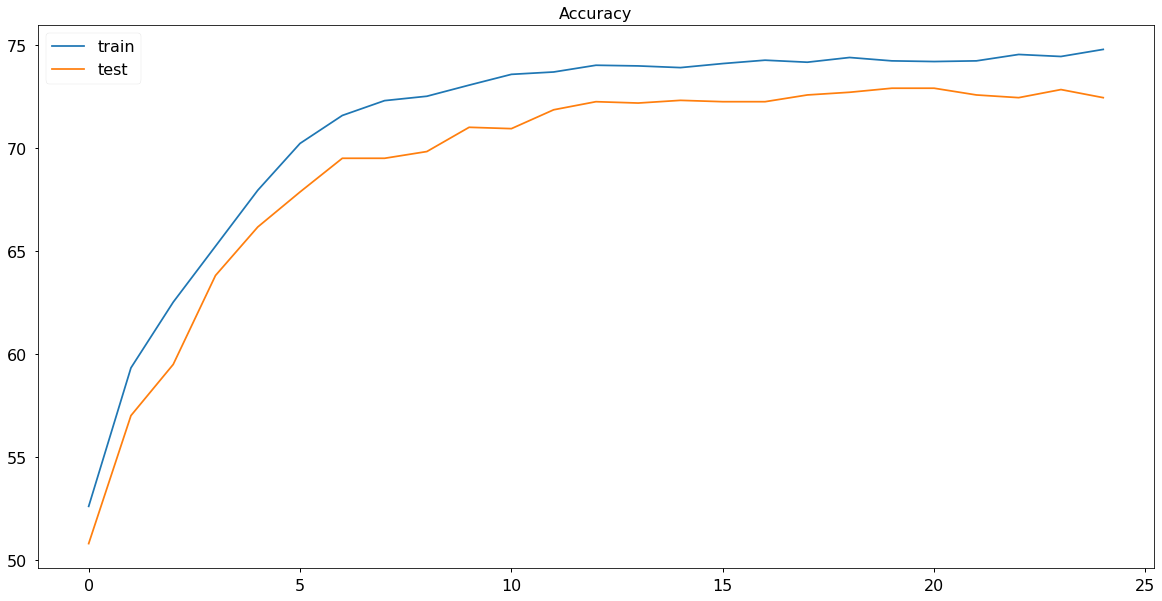

In [69]:
plt.plot(train_accuracy_history, label='train')
plt.plot(test_accuracy_history, label='test')
plt.legend();
plt.title('Accuracy');

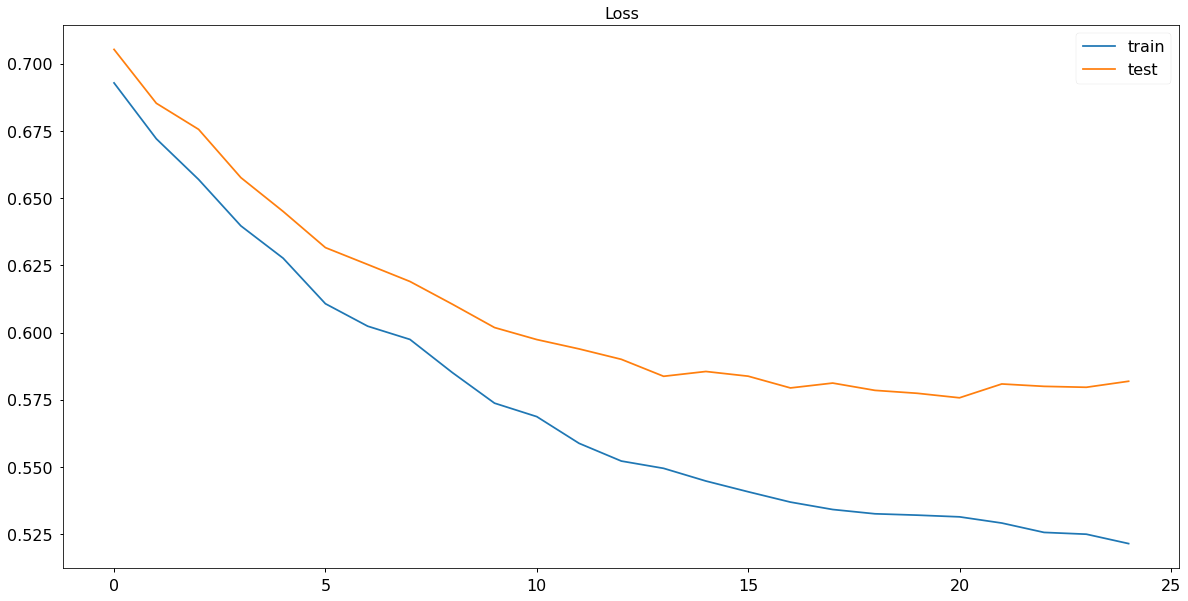

In [70]:
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();
plt.title('Loss');

In [71]:
net.eval()
with torch.no_grad():
    y_test_pred = net(X_test)
    y_test_pred = torch.round(torch.sigmoid(y_test_pred))

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.96      0.84      1128
         1.0       0.33      0.05      0.09       401

    accuracy                           0.72      1529
   macro avg       0.54      0.51      0.46      1529
weighted avg       0.63      0.72      0.64      1529



We can see that the model is unbalanced - it can detect 96% *bad*=0 samples with 74% precision and only 5% of *bad*=1 samples with 33% precision. Model almost always misses people, who won't repay the loan.

I guess, the main reason for these disappointing results is our decision to discard *approved*=0 samples. Firstly, there is class imbalance in our training data (~5600 *bad*=0 and ~2000 *bad*=1). Secondly, we missed significant data. *Approved*=0 samples are even more important than *bad*=1 ones.

Let's mark up our *bad*=*NaN* samples now instead of drop them out.

# Mark *NaN*s

In [72]:
df = df.fillna(1.0)

In [73]:
df_bad = df[df['bad'] == 1]
df_not_bad = df[df['bad'] == 0]

df_bad = df_bad.drop(['order_id', 'bad', 'approved'], axis=1)
df_not_bad = df_not_bad.drop(['order_id', 'bad', 'approved'], axis=1)

num_columns = df_bad.shape[1]

## Look at the features distributions for *bad*=1 and *bad*=0 again

In [74]:
# For subplots
nrow = num_columns
ncol = 2

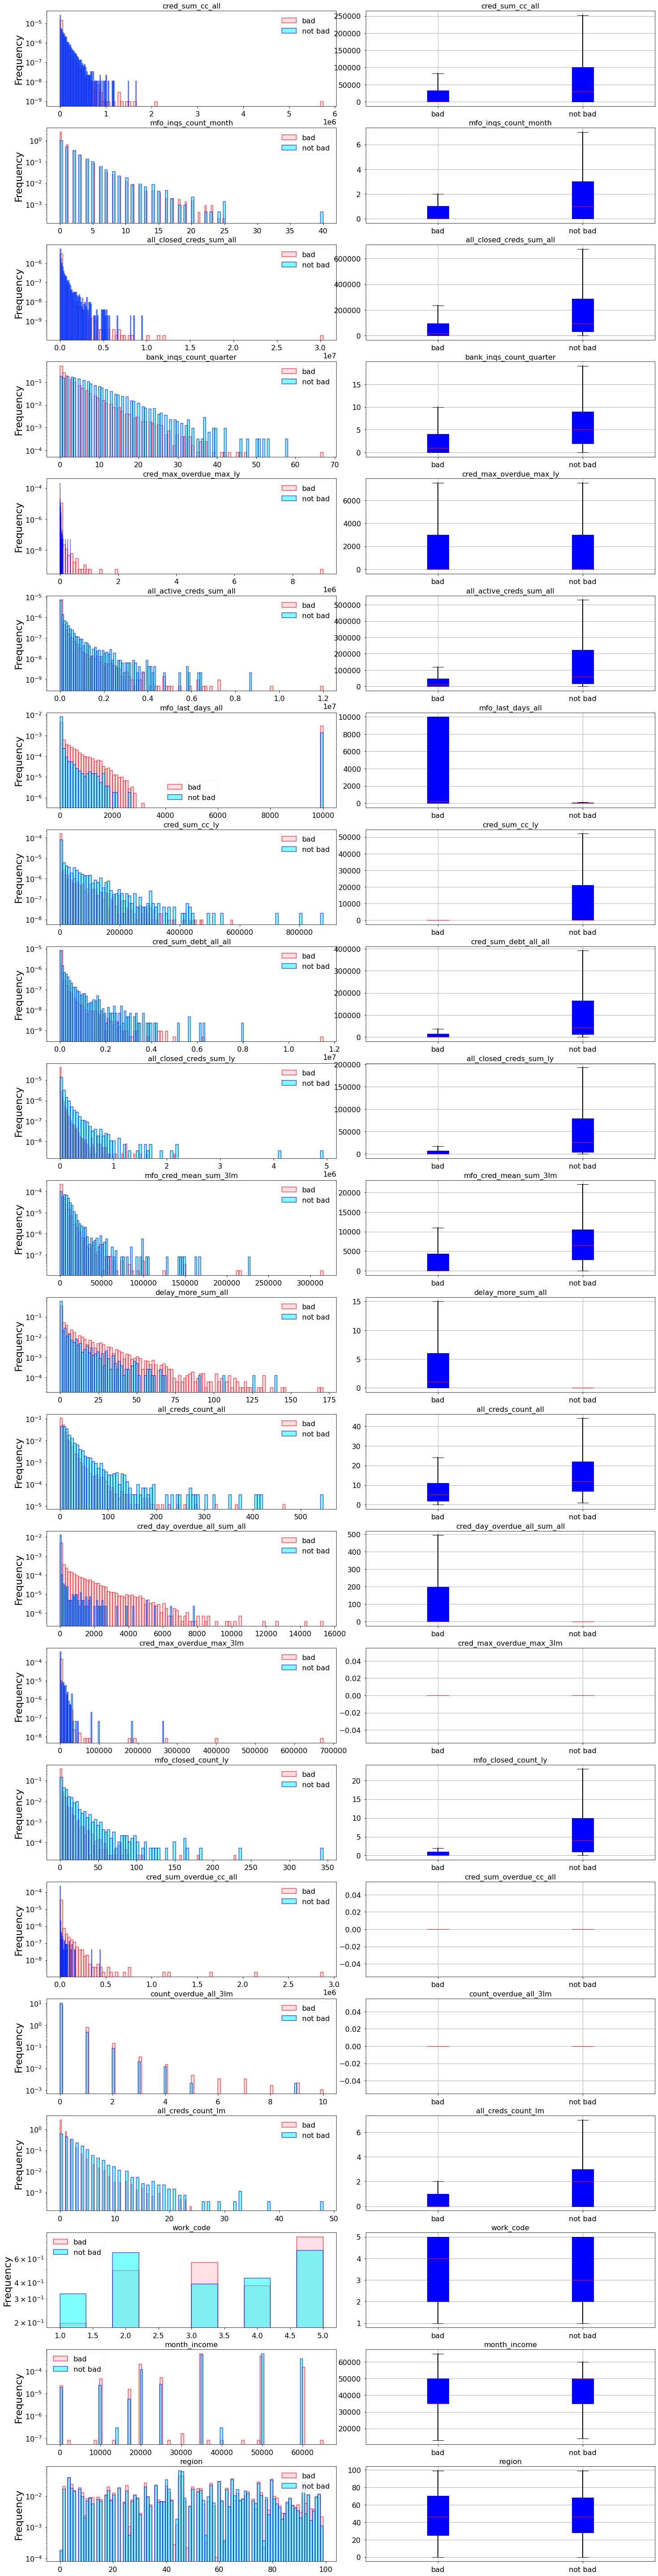

In [75]:
# Plotting hists

fig, axes = plt.subplots(nrow, ncol, figsize=(20,80))
fig.tight_layout()

hist_params = {'linewidth':2, 'density':True, 'log':True, 'alpha':0.5}
labels = ['bad', 'not bad']
color = dict(boxes='blue', whiskers='black', medians='red', caps='black')

for i in range(nrow):
    # Hists
    bins_num = 100 if df_bad.columns[i] != 'work_code' else 10
    df_bad[df_bad.columns[i]].plot.hist(**hist_params, color='pink', edgecolor='red', bins=bins_num, label='bad', ax=axes[i][0])
    df_not_bad[df_not_bad.columns[i]].plot.hist(**hist_params, color='cyan', edgecolor='blue', bins=bins_num, label='not bad', ax=axes[i][0])
    axes[i][0].legend()
    axes[i][0].set_title(f'{df_not_bad.columns[i]}')

    # Boxplots
    feature_pair = pd.concat([df_bad[[df_bad.columns[i]]], df_not_bad[[df_not_bad.columns[i]]]], axis=1)
    bp = feature_pair.boxplot(showfliers=False, patch_artist=True, ax=axes[i][1], whiskerprops = dict(linewidth=2.0, color='black'), color=color)
    bp.set_xticks(range(1, 3))
    bp.set_xticklabels(labels)
    axes[i][1].set_title(f'{df_not_bad.columns[i]}')

We won't drop any feature out before learning process, so leave it unchanged.

## Check if the classes are balanced

bad
1.0    18754
0.0     5580
dtype: int64


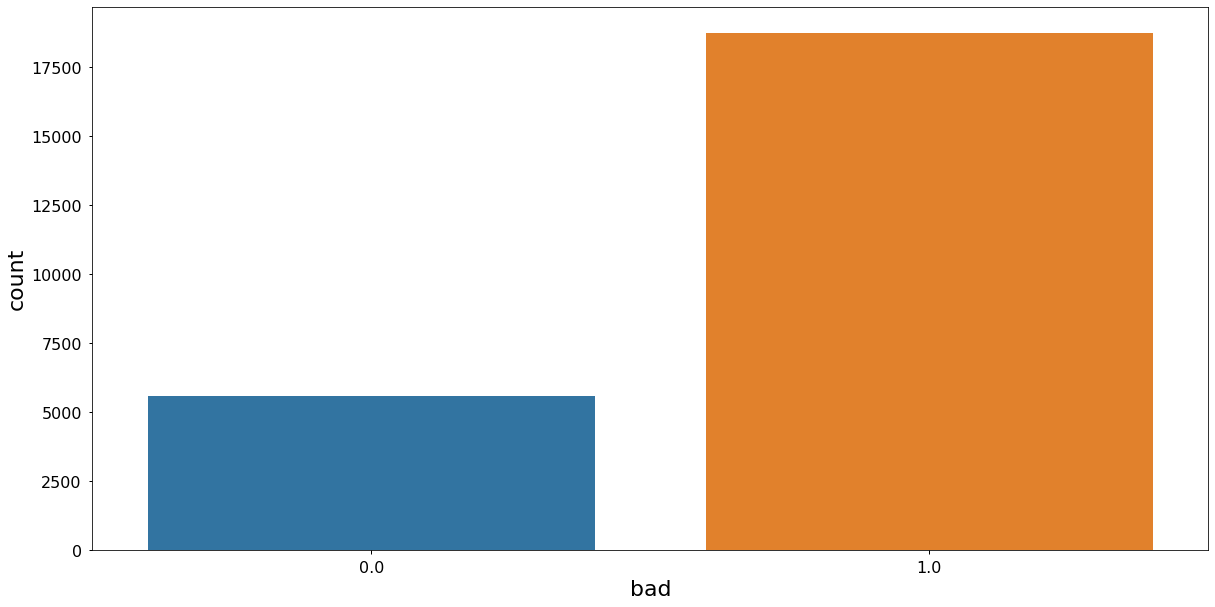

In [76]:
print(df.value_counts('bad'))
sns.countplot(x='bad', data=df);

We can see significant class imbalance here again, but on the contrary side. This may affect the result, but let's try to train the model on this data and see what will happen.

In [77]:
X = df.drop(['order_id', 'approved', 'bad'], axis=1)
y = df[['bad']]

## Train-test data preparation

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Scaling and converting to numpy

In [79]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [81]:
X_train.shape, X_test.shape

(torch.Size([17033, 22]), torch.Size([7301, 22]))

## Model

In [82]:
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE=0.0001

In [83]:
train_data = TrainData(X_train,y_train)
test_data = TestData(X_test)

In [84]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [85]:
net = BinaryClassificationBad(X_train.shape[1])

In [86]:
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=LEARNING_RATE)

## Learning

In [87]:
test_accuracy_history = []
test_loss_history = []
train_accuracy_history = []
train_loss_history = []

for e in range(1, EPOCHS+1):
    net.train()
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, target_batch in train_loader:
        optimizer.zero_grad()

        pred_batch = net(X_batch)

        loss_val = loss(pred_batch, target_batch)
        acc = binary_acc(pred_batch, target_batch)

        loss_val.backward()
        optimizer.step()

        epoch_loss += loss_val.item()
        epoch_acc += acc.item()

    net.eval()
    test_preds = net.forward(X_test)
    train_preds = net.forward(X_train)

    test_loss_history.append(loss(test_preds, y_test).item())
    test_accuracy_history.append(binary_acc(test_preds, y_test))

    train_loss_history.append(loss(train_preds, y_train).item())
    train_accuracy_history.append(binary_acc(train_preds, y_train))

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.59000 | Acc: 73.062
Epoch 002: | Loss: 0.52145 | Acc: 79.113
Epoch 003: | Loss: 0.47538 | Acc: 81.091
Epoch 004: | Loss: 0.43550 | Acc: 82.039
Epoch 005: | Loss: 0.40133 | Acc: 83.173
Epoch 006: | Loss: 0.37705 | Acc: 83.320
Epoch 007: | Loss: 0.36066 | Acc: 83.596
Epoch 008: | Loss: 0.35109 | Acc: 83.994
Epoch 009: | Loss: 0.34419 | Acc: 84.099
Epoch 010: | Loss: 0.33734 | Acc: 84.169
Epoch 011: | Loss: 0.33302 | Acc: 84.597
Epoch 012: | Loss: 0.32992 | Acc: 84.480
Epoch 013: | Loss: 0.32653 | Acc: 84.836
Epoch 014: | Loss: 0.32538 | Acc: 84.772
Epoch 015: | Loss: 0.32583 | Acc: 84.638
Epoch 016: | Loss: 0.32037 | Acc: 85.006
Epoch 017: | Loss: 0.32137 | Acc: 84.802
Epoch 018: | Loss: 0.31640 | Acc: 85.276
Epoch 019: | Loss: 0.31563 | Acc: 85.404
Epoch 020: | Loss: 0.31465 | Acc: 85.193
Epoch 021: | Loss: 0.31495 | Acc: 85.198
Epoch 022: | Loss: 0.31321 | Acc: 85.281
Epoch 023: | Loss: 0.31094 | Acc: 85.428
Epoch 024: | Loss: 0.31033 | Acc: 85.579
Epoch 025: | Los

## Results

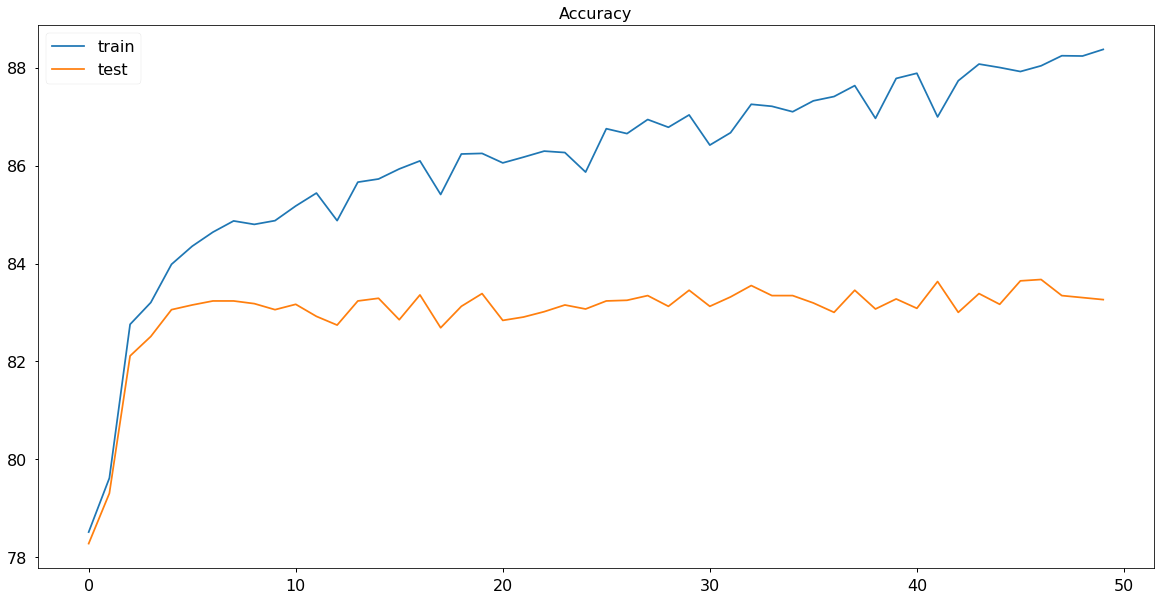

In [88]:
plt.plot(train_accuracy_history, label='train')
plt.plot(test_accuracy_history, label='test')
plt.legend();
plt.title('Accuracy');

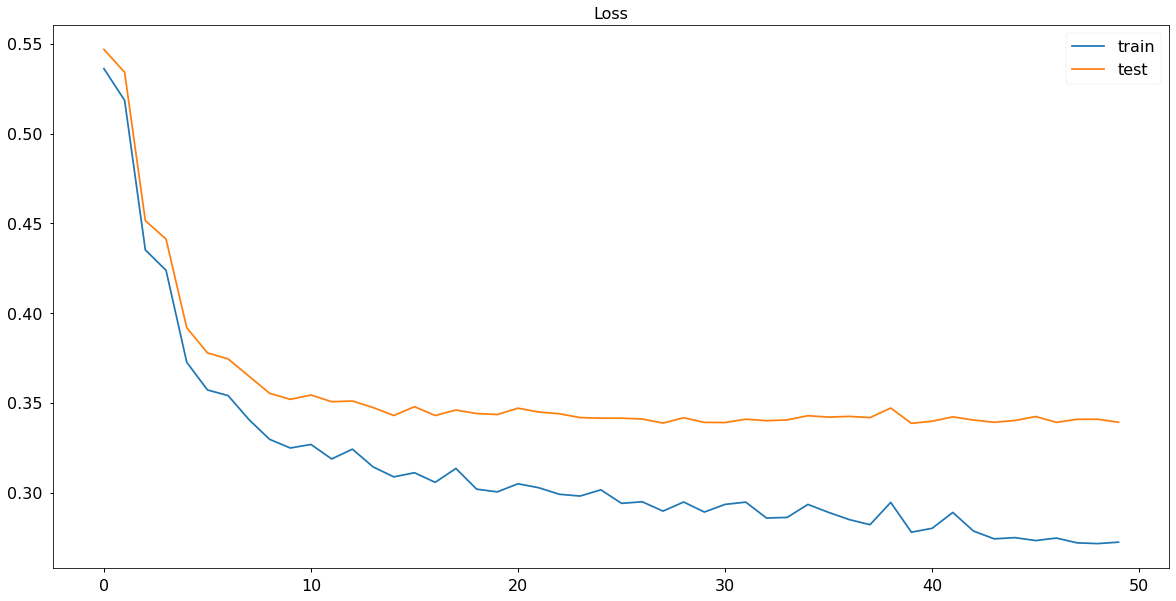

In [89]:
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();
plt.title('Loss');

In [90]:
net.eval()
with torch.no_grad():
    y_test_pred = net(X_test)
    y_test_pred = torch.round(torch.sigmoid(y_test_pred))

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.64      0.61      0.63      1677
         1.0       0.88      0.90      0.89      5624

    accuracy                           0.83      7301
   macro avg       0.76      0.75      0.76      7301
weighted avg       0.83      0.83      0.83      7301



Now the model works much better. It can detect 90% *bad*=1 samples with 88% precision. Total accuracy on 2 classes detecting is 83%.

But this model does not work well with *bad*=0 samples. It can detect only 61% of these samples with 64% precision.

# Summary
If we want our model to be very good at detecting persons, who won't repay loan, this one may be a good choice. We do not give the credit to persons marked *bad*=1 by the model, and we give it to all the remaining ones.

On the contrary, if we want our model to be very good at detecting reliable persons, we should not use it.

At the end, it all depends on purposes, metrics and statistics of the individual financial organizations.